In [1]:
import numpy as np
import random
import keras
import scipy.io as sio
from scipy.stats import skew, kurtosis
import pywt
import matplotlib.pyplot as plt
import json

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from keras import layers
from keras.layers import Input, Dropout, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, LSTM,Conv1D, AveragePooling1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional, TimeDistributed
from keras.models import Model, load_model, Sequential
from keras.preprocessing import image
from keras.utils import layer_utils, plot_model, to_categorical
from keras.utils.data_utils import get_file
from keras import optimizers
from keras import callbacks
from keras import regularizers
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import keras.backend as K
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.







['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
'''
Split data into train, dev, test. For this stage, we'll only split train/dev set.
'''

def get_dataset(mat_path='Formatted_Data/'):   
    path = mat_path
    files = os.listdir(path)

    X_train = []
    Y_train = []
    X_dev = []
    Y_dev = []
 
    mat_contents = sio.loadmat(path + 'mrkStage.mat')
        
    X_stk = mat_contents['mrkSticker']
    X_PSG = mat_contents['mrkPSG']
    Y_stk = np.transpose(mat_contents['mrkStickerLabel'])
    Y_PSG = np.transpose(mat_contents['mrkPSGLabel'])
        
    X_train = X_PSG
    Y_train = Y_PSG
        
    X_dev = X_stk
    Y_dev = Y_stk 

    return X_train, Y_train, X_dev, Y_dev

X_train, Y_train, X_dev, Y_dev = get_dataset()

'''
Switch to binary label case. I.E., all non-wake labels are lumped to 1.
'''
Y_train[Y_train== 2] = 0
Y_train[Y_train== 3] = 0
Y_train[Y_train== 4] = 0
Y_dev[Y_dev== 2] = 0
Y_dev[Y_dev== 3] = 0
Y_dev[Y_dev== 4] = 0


Y_train = to_categorical(Y_train)
Y_dev = to_categorical(Y_dev)

X_train = np.transpose(np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])), (0, 2, 1))
X_dev = np.transpose(np.reshape(X_dev, (X_dev.shape[0], 1, X_dev.shape[1])), (0, 2, 1))

In [3]:
def convolutional_block(X, f, filters, stage, block, s = 1):    
  
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
  
    X_shortcut = X

    X = Conv1D(F1, 1, strides = 1, padding='causal', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
  
    X = Conv1D(F1, f, strides = 1, padding='causal', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv1D(F3, 1, strides = 1, padding='causal', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2c')(X)

    X_shortcut = Conv1D(F3, 1, strides = s, padding='causal', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = -1, name = bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [4]:
def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv1D(filters = F1, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters = F2, kernel_size = f, strides = 1, padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters = F3, kernel_size = 1, strides = 1, padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2c')(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [5]:
def ResNet50_1D(input_shape = (6000, 1), classes = 5):
    
    X_input = Input(input_shape)
    X = X_input

    # Stage 1
    X = Conv1D(64, 6, strides = 1, name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1, name = 'bn_conv1')(X)
    print(X.shape)
    X = Activation('relu')(X)
    X = MaxPooling1D(3, strides=1)(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 128], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 128], stage=2, block='c')

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 256], stage = 3, block='a', s = 1)
    X = identity_block(X, 3, [128, 128, 256], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 256], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 256], stage=3, block='d')

    # Stage 4 
#     X = convolutional_block(X, f = 3, filters = [256, 256, 512], stage = 4, block='a', s = 1)
#     X = identity_block(X, 3, [256, 256, 512], stage=4, block='b')
#     X = identity_block(X, 3, [256, 256, 512], stage=4, block='c')
#     X = identity_block(X, 3, [256, 256, 512], stage=4, block='d')

    # AVGPOOL
    X = AveragePooling1D(pool_size=2)(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50_1D')
    print(model.summary())
    return model

In [6]:
model = ResNet50_1D(input_shape = (6000, 1), classes = 2)
class_weight = {0: 1,
                1: 10
                }

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train[:,:,:], Y_train[:], validation_data=(X_dev[:,:,:], Y_dev[:]), epochs = 3, batch_size = 32, class_weight=class_weight, shuffle=True)





(?, 5995, 64)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 6000, 1)      0                                            
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 5995, 64)     448         input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 5995, 64)     256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 5995, 64)     0           bn_conv1[0][0]                   
_________________________________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1320 samples, validate on 1320 samples
Epoch 1/3


1320/1320 [==============================] - 101s 77ms/step - loss: 22.1828 - acc: 0.8447 - val_loss: 2.2468 - val_acc: 0.8606
Epoch 2/3
1320/1320 [==============================] - 85s 64ms/step - loss: 22.4676 - acc: 0.8606 - val_loss: 2.2468 - val_acc: 0.8606
Epoch 3/3
1320/1320 [==============================] - 85s 64ms/step - loss: 22.4676 - acc: 0.8606 - val_loss: 2.2468 - val_acc: 0.8606


In [14]:
preds = model.evaluate(X_dev[0:20,:,:], Y_dev[0:20,:])
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))


20/20 [==============================] - 1s 39ms/step
Loss = 1.1920930376163597e-07
Test Accuracy = 1.0


In [15]:
# model.save('demo_1')
# np.save('demo_1', history)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["acc"]
val_acc = history.history["val_acc"]



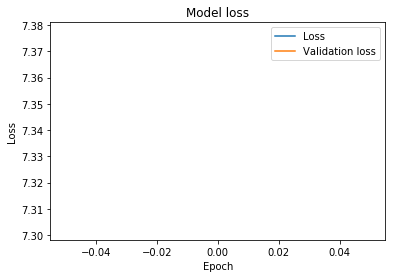

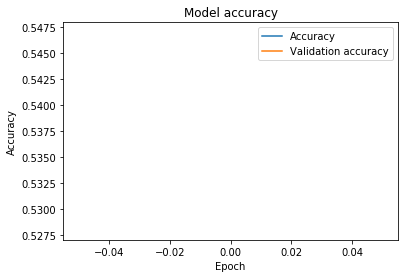

In [16]:
'''
Plot loss and accuracy
'''
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Loss","Validation loss"])
plt.show()

plt.plot(acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(["Accuracy","Validation accuracy"])
plt.show()